In [1]:
import pandas as pd; pd.options.mode.chained_assignment = None # default warn => SettingWithCopyWarning
import numpy as np
from datetime import datetime
import warnings; warnings.simplefilter(action='ignore', category=UserWarning)
from IPython.display import HTML, display
from ipywidgets import AppLayout, Button, Layout, VBox, HBox, Label, HTML, interact, IntSlider
import ipywidgets as widgets
import arrow

#import dmyplant2
from dmyplant2 import (
    cred, MyPlant, Engine, 
    msgFSM, filterFSM, FSMPlot_Start, 
    bokeh_show, dbokeh_chart, add_dbokeh_vlines, get_cycle_data2, 
    disp_result, alarms_pareto, warnings_pareto, states_lines,
    detect_edge_right, detect_edge_left)
    
cred()
mp = MyPlant(3600)
Engine._list_cached_validations()

,1486144,1486174
Asset ID,159396,159398
Validation Engine,Forsa Hartmoor M01,Forsa Hartmoor M04
n,999,999
oph@start,63.0,44.0
serialNumber,1486144,1486174
starts@start,74.0,61.0
val start,2022-01-10 00:00:00,2022-01-11 00:00:00
source,from_MyPlant,from_MyPlant


In [2]:
def sfun(x):
    return all([ ("Forsa Hartmoor" in str(x['IB Site Name'])),  (x['OperationalCondition'] != 'Decommissioned') ])
fleet = mp.search_installed_fleet(sfun).drop('index', axis=1)
fleet = fleet.sort_values(by = "Engine ID",ascending=True).reset_index(drop='index')
fleet.T;

In [3]:
motor = fleet.iloc[3]
modes = ['???','OFF','MANUAL','AUTO']
success = [True,False]
#success = [True]
motor['IB Site Name'] + ' ' + motor['Engine ID'], modes, success

('Forsa Hartmoor M04', ['???', 'OFF', 'MANUAL', 'AUTO'], [True, False])

In [4]:
e=Engine.from_fleet(mp,motor)
#fsm = msgFSM(e, p_from=e['Commissioning Date'], p_to=datetime.now(), frompickle=False, successtime=600)
fsm = msgFSM(e, p_to='2022-02-01', frompickle=False, successtime=600)
fsm.run1(enforce=True) # run Finite State Machine
fsm.store()
fsm.result;

FSM: 100%|████████████████████████| 9256/9256 [00:00<00:00, 13475.78 messages/s]


In [5]:
rdf = fsm.result
rda = rdf[:].reset_index(drop='index')
rda = rda[(rda['mode'].isin(modes) & rda['success'].isin(success))].reset_index(drop='index')
display(HTML(pd.DataFrame.from_dict(e.dash, orient='index').T.to_html(escape=False, index=False)))
#rda[filterFSM.run2filter_content].round(2)
print(f"Starts: {rdf.shape[0]}, Successful: {rdf[rdf['success'] == True].shape[0]}, Failed: {rdf[rdf['success'] == False].shape[0]} => {rdf[rdf['success'] == True].shape[0]/rdf.shape[0]*100.0:3.1f}%")

HTML(value='<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>Na…

Starts: 106, Successful: 55, Failed: 51 => 51.9%


In [6]:
rda[filterFSM.run2filter_content]

,no,success,mode,startpreparation,starter,hochlauf,idle,synchronize,loadramp,cumstarttime,maxload,ramprate,targetoperation,rampdown,coolrun,runout,count_alarms,count_warnings
0,0,False,MANUAL,305.440999,NaN,NaN,NaN,NaN,NaN,305.440999,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,1,False,MANUAL,292.932000,3.934999,26.238,NaN,NaN,NaN,323.104999,NaN,NaN,NaN,NaN,NaN,NaN,0,1
2,2,False,MANUAL,64.848000,NaN,NaN,NaN,NaN,NaN,64.848000,NaN,NaN,NaN,NaN,NaN,NaN,1,0
3,3,False,MANUAL,44.796999,NaN,NaN,NaN,NaN,NaN,44.796999,NaN,NaN,NaN,NaN,NaN,NaN,1,0
4,4,False,MANUAL,175.835000,3.524999,19.972,40.593999,NaN,NaN,239.926000,NaN,NaN,NaN,NaN,NaN,NaN,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,101,True,AUTO,79.523000,4.132000,18.555,4.140000,31.168000,139.165999,45483.726000,NaN,NaN,45020.332000,127.611,9.981999,49.117000,0,0
102,102,True,AUTO,100.072000,3.732000,19.990,4.336000,1.413999,146.844999,2285.179000,NaN,NaN,1822.544999,127.508,9.981999,48.755000,0,0
103,103,True,AUTO,100.389999,3.620999,25.816,4.542000,4.136999,137.892000,13684.851999,NaN,NaN,13222.301999,127.370,10.007000,48.774999,0,0
104,104,True,AUTO,97.091000,3.640999,22.916,4.640999,4.424999,143.491000,5885.099000,NaN,NaN,5422.724999,127.355,9.990000,48.824000,0,1


In [7]:
# %load_ext autoreload
# %aimport -pandas, -numpy
# %autoreload 2
# Execute FSM Run 2
rda = fsm.run2(rda, silent=False)
fsm.store()

FSM Run2: 100%|██████████████████████████| 106/106 [01:04<00:00,  1.63 starts/s]


In [8]:
#rdb = rda[(rda['mode'].isin(['AUTO','MANUAL'])) & ((rda['count_alarms'] > 0) | (rda['count_warnings'] > 0))]
#rdb = rda[rda['synchronize'] < 15.0]
rdb = rda
#rdb[filterFSM.run2filter_content].sort_values(by=["synchronize","loadramp"], ascending=[True,True]).round(2)

,startpreparation,hochlauf,idle,synchronize,loadramp,maxload,ramprate,cumstarttime,targetoperation,rampdown,coolrun,runout
count,106.00,90.00,76.00,71.00,70.00,106.00,70.00,106.00,61.00,61.00,61.00,54.00
mean,265.00,21.34,12.69,22.03,165.09,3372.15,0.64,419.36,9347.51,126.69,13.50,48.74
std,1045.58,4.53,21.27,16.92,243.34,1796.52,0.25,1040.75,12826.59,101.94,11.27,0.27
min,1.92,3.23,4.04,0.40,-879.22,0.00,-0.00,0.22,0.20,0.30,0.91,48.02
25%,80.32,19.57,4.64,9.54,127.85,2638.00,0.64,236.97,1638.30,127.23,9.99,48.64
50%,98.90,20.98,5.56,21.68,130.21,4492.73,0.77,278.51,5076.48,127.43,9.99,48.75
75%,126.18,23.28,6.28,34.82,144.93,4503.00,0.78,307.96,13222.30,127.56,10.00,48.90
max,10677.49,42.47,140.75,104.20,1585.91,4524.93,0.95,10677.49,74194.23,848.87,48.85,49.34


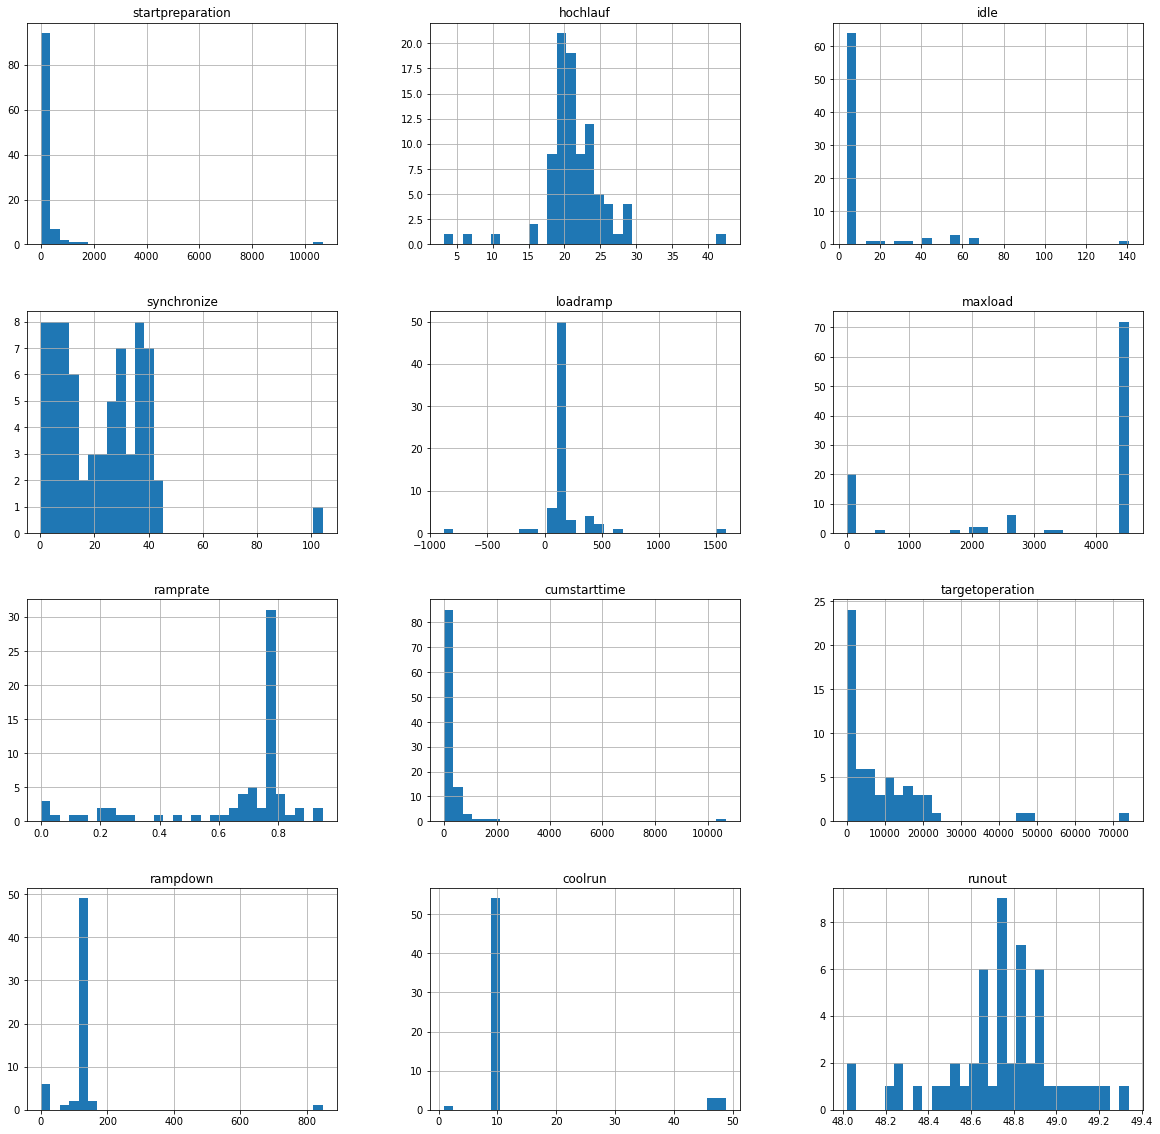

In [9]:
vec = ['startpreparation','hochlauf','idle','synchronize','loadramp','maxload','ramprate','cumstarttime','targetoperation','rampdown','coolrun','runout']
display(_=rdb[vec].hist(bins=30,figsize=(20,20)))
display(rdb[vec].describe().round(2))

In [10]:
rde = rda[(rda.starttime > fsm._e['Commissioning Date']) & (rda['success'])].copy()
rde['datetime'] = pd.to_datetime(rde['starttime'])
dfigsize = (12,8)
dset = [
    {'col':['cumstarttime'],'ylim':(-400,900), 'color':'darkblue'},
    {'col':['synchronize'],'ylim':(-20,300)},
    {'col':['startpreparation'],'ylim':(-600,300)},
    {'col':['hochlauf'],'ylim':(-100,200), 'color':'orange'},
    {'col':['loadramp'],'ylim':(-150,900), 'color':'red'},
    {'col':['ramprate'],'ylim':(-3,3)},
    {'col':['no'],'ylim':(-100,10000),'color':'black'},
    {'col':['maxload'],'ylim':(500,5000) }
]
ftitle = f"{fsm._e}"
fig = dbokeh_chart(rde, dset, style='both', figsize=dfigsize ,title=ftitle);
bokeh_show(fig)
del(fig)

In [11]:
vset = ['Various_Values_SpeedAct','Power_PowerAct','Hyd_PressCrankCase','Hyd_PressOilDif','Hyd_PressOil','Hyd_TempOil']
dset = [
    {'col':['Power_PowerAct'], 'ylim':(0,5000), 'color':'red'},
    {'col':['Various_Values_SpeedAct'],'ylim': [0, 2500], 'color':'blue'},
    #{'col':['Hyd_PressCrankCase'],'ylim': [-100, 100], 'color':'orange'},
    #{'col':['Hyd_PressOilDif'],'ylim': [0, 2], 'color':'black'},
    {'col':['Hyd_PressOil'],'ylim': [0, 10], 'color':'brown'},
    {'col':['Hyd_TempOil'],'ylim': [0, 110], 'color':'#2171b5'}
]


In [12]:
from pprint import pprint as pp, pformat as pf

def plot_with_additional_results(
        startversuch, 
        vset=None, 
        dset = [
        {'col':['Power_PowerAct'], 'ylim':(0,5000), 'color':'red'},
        {'col':['Various_Values_SpeedAct'],'ylim': [0, 2500], 'color':'blue'}
    ]):

    if vset == None:
        vset = []
        for rec in dset:
            for d in rec['col']:
                vset.append(d) 
        vset = list(set(vset))

    data = get_cycle_data2(fsm, startversuch, max_length=None, min_length=None, cycletime=1, silent=False, p_data=vset)
    fig = FSMPlot_Start(fsm, startversuch, data, vset, dset, figsize=dfigsize); 
    #fsm run 2 results
    lcol='blue'
    pl, _ = detect_edge_left(data, 'Power_PowerAct', startversuch)
    pr, _ = detect_edge_right(data, 'Power_PowerAct', startversuch)
    sl, _ = detect_edge_left(data, 'Various_Values_SpeedAct', startversuch)
    sr, _ = detect_edge_right(data, 'Various_Values_SpeedAct', startversuch)
    add_dbokeh_vlines([sl.loc], fig,line_color=lcol, line_dash='solid', line_alpha=0.4)
    add_dbokeh_vlines([sr.loc], fig,line_color=lcol, line_dash='solid', line_alpha=0.4)
    add_dbokeh_vlines([pl.loc], fig,line_color=lcol, line_dash='solid', line_alpha=0.4)
    add_dbokeh_vlines([pr.loc], fig,line_color=lcol, line_dash='solid', line_alpha=0.4)

    #pp(startversuch['timing']) # ['timings']['start_loadramp'])
    add_dbokeh_vlines([startversuch['timing']['end_loadramp']], fig,line_color='green', line_dash='solid', line_alpha=0.4)

    #new_lines = [startversuch['starttime']] + [startversuch[k] for k in startversuch.keys() if k.endswith('_time')]
    #add_dbokeh_vlines(new_lines,fig,line_color='green', line_dash='solid', line_alpha=0.4)
    bokeh_show(fig)
    del(fig)

In [13]:
rdb[filterFSM.run2filter_content].sort_values(by=["synchronize","loadramp"], ascending=[True,True]).round(2)

,no,success,mode,startpreparation,starter,hochlauf,idle,synchronize,loadramp,cumstarttime,maxload,ramprate,targetoperation,rampdown,coolrun,runout,count_alarms,count_warnings
35,35,True,MANUAL,99.77,3.64,16.24,57.62,0.40,129.53,307.20,4495.40,0.77,875.09,127.56,9.99,48.02,0,2
65,65,True,AUTO,75.27,4.04,19.69,5.56,1.21,132.00,237.77,4504.00,0.76,15151.95,127.62,10.00,48.76,0,1
41,41,True,AUTO,60.63,4.74,19.58,5.34,1.32,375.16,466.77,4499.00,0.27,1461.11,166.62,10.02,48.98,0,2
102,102,True,AUTO,100.07,3.73,19.99,4.34,1.41,152.40,281.94,4504.00,0.66,1822.54,127.51,9.98,48.76,0,0
37,37,False,OFF,60.58,3.73,20.70,5.66,1.51,128.14,220.32,4487.34,0.78,576.92,127.52,9.99,48.20,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,68,False,AUTO,106.12,4.14,21.08,NaN,NaN,NaN,131.34,4519.00,NaN,NaN,NaN,NaN,NaN,0,0
80,80,False,MANUAL,489.45,NaN,NaN,NaN,NaN,NaN,489.45,1773.08,NaN,NaN,NaN,NaN,NaN,0,0
85,85,False,MANUAL,439.21,NaN,NaN,NaN,NaN,NaN,439.21,0.00,NaN,NaN,NaN,NaN,NaN,0,0
99,99,False,MANUAL,380.54,NaN,NaN,NaN,NaN,NaN,380.54,4492.00,NaN,NaN,NaN,NaN,NaN,0,0


In [14]:
def f(x=0):
    global v; v = x; startversuch = rdb.iloc[x]
    ftitle = f"{fsm._e} ----- Start {startversuch['no']} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}"
    display(HTML(ftitle));
    disp_result(startversuch)
interact(f, x = IntSlider(0, 0, rdb.shape[0]-1 , 1, layout=widgets.Layout(width='70%')));

interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='70%'), max=105), Output()), _do…

HTML(value='1486174 Forsa Hartmoor M04 ----- Start 0 MANUAL | FAILED | 2021-11-17 16:17:47')

In [16]:
startversuch = rdb.iloc[v]; plot_with_additional_results(startversuch, vset, dset) 

von: 25.11.2021 17:12:38 bis: 25.11.2021 18:45:05


In [ ]:
startversuch = rdb.iloc[v]
display(HTML(pd.DataFrame.from_dict(dict(zip(filterFSM.vertical_lines_times, states_lines(startversuch))), orient='index').T.to_html(escape=False,index=False)))
td = {
    'start': [v for k,v in startversuch['timing'].items() if k.startswith('start_')],
    'end': [v for k,v in startversuch['timing'].items() if k.startswith('end_')]
}
columns = [k[4:] for k in startversuch['timing'].keys() if k.startswith('end_')]
#display(HTML(pd.DataFrame.from_dict(td,orient='index').T.to_html(escape=False,index=False)))
pd.DataFrame.from_dict(td,orient='index', columns=columns)

In [ ]:
nalarms = []
ct = 0
ct2 = 0
mini = 0
maxi = 100
_txt = ''
for i,c in rdf.iterrows():
    if len(c['alarms']) > 0 and not c['success']:
        ct += 1
        _txt += f"<h3>Startversuch: {i}, Success: {c['success']}</h3>"
        #display(HTML(f"\n<hr><h3>Startversuch: {i}, Success: {c['success']}</h3>"))
        print()
        for a in c['alarms']:
            nalarms.append(a['msg'])
            _txt += f"{ct2} {c['mode']:15} {a['state']:20} " + fsm.msgtxt(a['msg']) + "<br>"
            #_txt = f"{ct2} {c['mode']:15} {a['state']:20} {a['msg']['timestamp']} {pd.to_datetime(int(a['msg']['timestamp'])*1e6).strftime('%d.%m.%Y %H:%M:%S')} {a['msg']['name']} {a['msg']['message']}"
            #if ct2 >= mini and ct2 <= maxi:
                #fsm.plot_cycle(c, ylim=(0,2500), cycletime=1, marker=None,figsize=(20,12), title=f"{i:3d} - {fsm._e} {_txt}")
                #plt.show()
            ct2 += 1
_txt = f"<h2>{fsm._e}, <br>{ct:3} not successful starts</h2>" + _txt
display(HTML(_txt))


In [ ]:
rdf['alarms']

In [ ]:
%load_ext autoreload
%aimport -pandas, -numpy
%autoreload 2
phases = [['startpreparation','starter','hochlauf','idle','synchronize','loadramp','targetoperation','coolrun'],'startpreparation','starter','hochlauf','idle','synchronize','loadramp','targetoperation','coolrun']
for phase in phases:
    al = alarms_pareto(fsm, phase)
    if not al.empty:
        display(HTML(f"<h3>{phase}:</h3>"))
        al.sort_values(by = "anz",ascending=True)
        display(HTML(al.to_html(escape=False, index=False)))

In [ ]:
for phase in phases:
    wr = warnings_pareto(fsm, phase)
    if not wr.empty:
        display(HTML(f"<h3>{phase}:</h3>"))
        wr.sort_values(by = "anz",ascending=True)
        display(HTML(wr.to_html(escape=False, index=False)))

In [ ]:
display(HTML(pd.DataFrame(fsm._runlog).to_html(escape=False, index=False)))

In [ ]:
mfn = e._fname + '_messages.txt'
fsm.save_messages(mfn)
print(mfn)

In [ ]:
from dmyplant2 import operationFSM
ofsm = operationFSM(e)
ofsm.dot(e._fname + 'FSM.dot')

In [ ]:
# lfn = e._fname + '_runlog.txt'
# fsm.save_runlog(lfn)
# print(lfn)